
<h2 align="center">Implementación de modelos ANN para clasificación de objetos astrofísicos identificados por el SDSS</h2>
<h2 align="center">( Galaxias, Estrellas y Quasars)</h2>



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Este conjunto de datos está formado por 10.000 registros de observaciones asociadas a objetos astrofisicos. Cada observación se describe mediante 17 columnas de características y 1 columna de etiqueta que identifica la observación como una estrella, una galaxia o un Quásar, a continuación se muestra la base de datos.


---

## Cargando la base de datos

---

In [2]:
import pandas as pd
url = 'https://raw.githubusercontent.com/joaramirezcu/Mineria_Proyecto/master/Skyserver_SQL2_27_2018%206_51_39%20PM.csv'
data_f1 = pd.read_csv(url, error_bad_lines=False)
data_f1=data_f1.drop(['rerun'], axis=1)
data_f1.head()

,objid,ra,dec,u,g,r,i,z,run,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [3]:
dim=display(data_f1.shape)

(10000, 17)

Se seleccionan las variables asociadas a la respuesta espectral las cuales hacen referencia a 7 variables fotométricas:

* **ra** : Ascensión recta (banda r)
* **dec**: declinación J2000 (banda r)
* **u**: Ajuste de magnitud 1
* **g**: Ajuste de magnitud 2
* **r**: Ajuste de magnitud 3
* **i**: Ajuste de magnitud 4
* **z**: Ajuste de magnitud 5

Además se considera una variable espectral la cual hace referencia a:

* **redshif**: desplazamiento al rojo

No obstante la variable **class** la cual es categórica y tiene la etiqueta de las observaciones realizadas por el telescopio SDS.

* **class**: tiene niveles: **STAR**, **GALAXY**, **QSO**

In [4]:
X = data_f1.iloc[:, [1,2,3,4,5,6,7,13]]
Y = data_f1.iloc[:, [12]]
Y = Y.replace({"GALAXY":0, "STAR":1,"QSO":2})
print(X.head())


           ra       dec         u  ...         i         z  redshift
0  183.531326  0.089693  19.47406  ...  15.50342  15.22531 -0.000009
1  183.598371  0.135285  18.66280  ...  16.48922  16.39150 -0.000055
2  183.680207  0.126185  19.38298  ...  17.08732  16.80125  0.123111
3  183.870529  0.049911  17.76536  ...  15.98233  15.90438 -0.000111
4  183.883288  0.102557  17.55025  ...  16.55492  16.61326  0.000590

[5 rows x 8 columns]


0    4998
1    4152
2     850
Name: class, dtype: int64


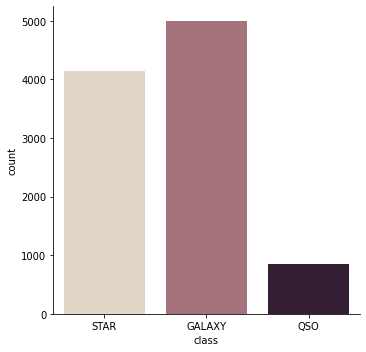

In [5]:
sns.catplot(x="class", kind="count", palette="ch:.25", data=data_f1);
print(Y["class"].value_counts())

Según la gráfica anterior, se puede identificar que de 10.000 observaciones realizadas por el telescopio del SDSS, 4.998 son Galaxias, 4.152 son estrellas y 850 son quasar.

In [6]:
correlation_dat = X.corr()
correlation_dat.style.background_gradient(cmap='coolwarm', axis=None)

,ra,dec,u,g,r,i,z,redshift
ra,1.000000,0.003596,0.031238,0.043909,0.047103,0.045731,0.042950,0.030307
dec,0.003596,1.000000,0.035279,0.061875,0.063404,0.058292,0.056870,0.067021
u,0.031238,0.035279,1.000000,0.849232,0.692379,0.602630,0.551483,0.163741
g,0.043909,0.061875,0.849232,1.000000,0.958106,0.907419,0.879622,0.407576
r,0.047103,0.063404,0.692379,0.958106,1.000000,0.977672,0.969197,0.441080
i,0.045731,0.058292,0.602630,0.907419,0.977672,1.000000,0.981507,0.431450
z,0.042950,0.056870,0.551483,0.879622,0.969197,0.981507,1.000000,0.424034
redshift,0.030307,0.067021,0.163741,0.407576,0.441080,0.431450,0.424034,1.000000


---
## Dividiendo los datos de entrenamiento y de validación
---

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [10]:
y = to_categorical(Y)
X_std = StandardScaler().fit_transform(X)

In [11]:
print(X_std,y)

[[ 0.16745842 -0.58492272  1.03148637 ... -0.94605772 -0.99534154
  -0.36973112]
 [ 0.16886159 -0.58311429  0.05243046 ... -0.08264457 -0.02604308
  -0.36984929]
 [ 0.17057433 -0.58347525  0.92156796 ...  0.44120145  0.31452753
  -0.05302706]
 ...
 [-0.92039468  1.46090664  0.16753826 ...  0.74398287  0.82921097
  -0.37074104]
 [-0.92197294  1.46432109  0.31801835 ...  0.6825157   0.59598555
  -0.33364691]
 [-0.91804124  1.46639319  0.79229193 ... -0.65522289 -0.76214106
  -0.06510125]] [[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


*train_test_split* es una función en la selección del modelo de Sklearn para dividir matrices de datos en dos subconjuntos : datos para entrenamiento y datos para prueba. No obstante, *train_test_split* hará particiones aleatorias para los dos subconjuntos. Esta función toma como parámetros el conjunto de datos *X_std* y las etiquetas *y*.

*train_size* es el otro parámetro y establece el tamaño del conjunto de datos de entrenamiento, en este caso se usa 0.2 el cual hace referencia a 80% para test y 20% para prueba.

In [12]:
X_trainT , X_test ,Y_trainT, Y_test = train_test_split(X_std , y , test_size=0.2)
X_train , X_test10 ,Y_train, Y_test10 = train_test_split(X_trainT , Y_trainT , test_size=0.125)

---
## Modelo perceptrón multicapa
---

Considerando que las redes neuronales son grupo de neuronas distribuidas en capas y conectadas por sus pesos (salidas con un valor asignado a la información que recibieron) se procede a describir el modelo ANN por medio de:

**Primera capa**

* Capa densa de 5 neuronas y entrada de tamaño 8, con función de activación ReLu (Unidad rectificada lineal). Además un dropout de 0.45.

**Segunda capa**

* Una capa densa con 256 neuronas y función de activación ReLu (Unidad rectificada lineal) y dropout de 0.45.

**Tercera capa**

* Una capa densa con 3 neuronas y función de activación Softmax.

Caba aclarar que los lotes son de tamaño 128.


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical, plot_model

In [17]:
input_size = 8
num_labels = 3
batch_size = 128
dropout = 0.45

In [18]:
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(Dense(5, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 45        
_________________________________________________________________
activation_3 (Activation)    (None, 5)                 0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1536      
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

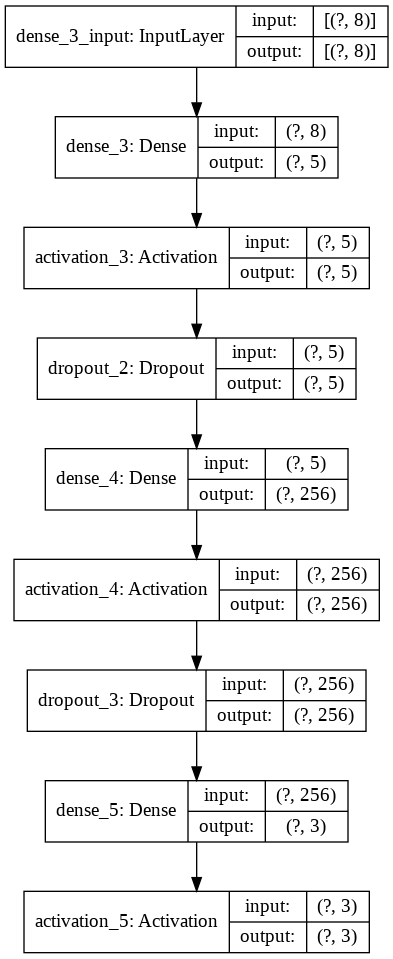

In [19]:
plot_model(model, show_shapes=True)

---
## Compilación
---

Un algoritmo de deep learning demora tanto en entrenar (entre otras cosas) porque eventualmente encuentra muchos mínimos locales en la superficie de error. 

###  Función de activación

En este proceso de entrenamiento, la función de Activación softmax
se describe matemáticamente como:

$$
\begin{equation}
Prob[y=j|x] = \frac{\exp(x_j)}{\sum_{k=1}^{n}\exp(x_j)}
\end{equation}
$$

Un cálculo muy estable computacionalmente de estos valores se obtiene de la siguente manera. Sea $\eta = \underset{i}{\text{max}} \hspace{2mm} \{x_i\}$. Es fácil verificar que

$$
\begin{equation}
Prob[y=j|x] = \frac{\exp(x_j-\eta)}{\sum_{k=1}^{n}\exp(x_k-\eta)} = \text{softmax}_j(x)
\end{equation}
$$

Observe que $\log \text{softmax}_j(x)  = x_j - \eta - \log(\sum_{k=1}^n \exp(x_k-\eta))$.


La variable *eta* en la función corresponde al máximo de los valores, no obstante para un conjunto de valores $x_1,\ldots,x_n$, la función softwax transforma estos valores en la escala (0,1), que pueden interpretarse como probabilidades. Cada componente de softmax es interpretada como la probabilidad que la imagen pertenezca a la clase representada por dicha componente.

No obstante en el procedimiento se procede a:

* Usar el **Backpropagation** que es un método para actualizar los pesos en la dirección (gradiente) que minimiza una métrica de error predefinida (en este caso relu), también es conocida como Función de Pérdida o Función de costo, dado un conjunto de observaciones etiquetadas. Este algoritmo ha sido repetidamente redescubierto y es un caso especial de una técnica más general llamada diferenciación automática en modo acumulativo reverso.

* En este proceso de compilación se especifica el optimizador, en este caso **Adam**
* Así mismo, se especifica la función de pérdida el cual puede ser (categorical_crossentropy o mse), aquí se considerará *categorical_crossentropy*

* Como se trata de un problema de clasificación,se establece que la métrica para evaluar el modelo está caracterizada por el  *accuracy*

In [ ]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

---
## Entrenamiento del modelo
---

Aquí se caracterizará el checkpoint para poder guardar el modelo y después poder usarlo para hacer predicciones.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import backend as K

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 0.99 accuracy so cancelling training!")
            self.model.stop_training = True

# crea una instancia de clase
accu_callback = myCallback()

In [ ]:
# Directory where the checkpoints will be saved
import os 
checkpoint_dir = './training_checkpoints_mnist_mlp'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "mnist_mlp_ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True, 
    monitor='val_accuracy', mode='max',
    save_best_only=True)

Se procede a realizar el entrenamiento del modelo ANN que fue caracterizado en lineas anteriores con epoch de tamaño 20 y un tamaño de validación de 0.2. 

In [ ]:
epochs = 50
validation_size =0.2

history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=validation_size,
                    callbacks=[accu_callback,checkpoint_callback],
                    verbose=2)

Epoch 1/50
44/44 - 0s - loss: 1.0041 - accuracy: 0.5093 - val_loss: 0.8589 - val_accuracy: 0.6629
Epoch 2/50
44/44 - 0s - loss: 0.8415 - accuracy: 0.5791 - val_loss: 0.7252 - val_accuracy: 0.6629
Epoch 3/50
44/44 - 0s - loss: 0.7623 - accuracy: 0.5943 - val_loss: 0.6688 - val_accuracy: 0.6736
Epoch 4/50
44/44 - 0s - loss: 0.7218 - accuracy: 0.6036 - val_loss: 0.6330 - val_accuracy: 0.6836
Epoch 5/50
44/44 - 0s - loss: 0.6737 - accuracy: 0.6223 - val_loss: 0.5964 - val_accuracy: 0.6900
Epoch 6/50
44/44 - 0s - loss: 0.6464 - accuracy: 0.6425 - val_loss: 0.5550 - val_accuracy: 0.7350
Epoch 7/50
44/44 - 0s - loss: 0.6235 - accuracy: 0.6523 - val_loss: 0.5291 - val_accuracy: 0.7164
Epoch 8/50
44/44 - 0s - loss: 0.5987 - accuracy: 0.6745 - val_loss: 0.4897 - val_accuracy: 0.8621
Epoch 9/50
44/44 - 0s - loss: 0.5872 - accuracy: 0.7018 - val_loss: 0.4588 - val_accuracy: 0.8771
Epoch 10/50
44/44 - 0s - loss: 0.5528 - accuracy: 0.7254 - val_loss: 0.4249 - val_accuracy: 0.8936
Epoch 11/50
44/44 -

---
### Evaluación del modelo ANN
---

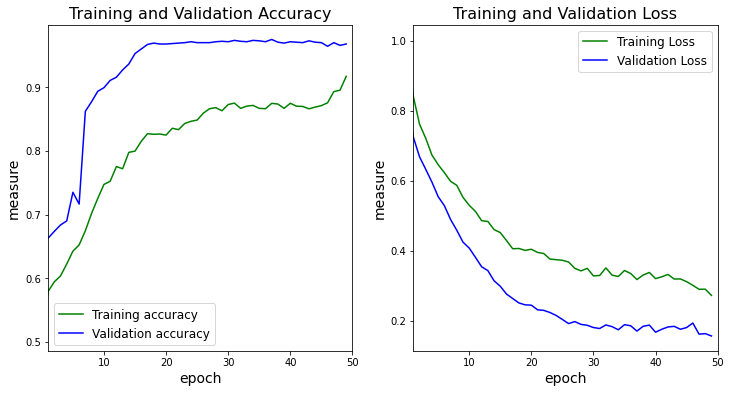

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

n_row = 1
n_col = 2
fig, ax = plt.subplots(n_row, n_col, sharex = False, sharey = False, figsize=(12,6))


ax[0].plot(epochs, acc, 'r', label='Training accuracy', color = 'green')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].legend(fontsize=12,loc=0)
ax[0].set_title('Training and Validation Accuracy',fontsize=16)
ax[0].set_ylabel('measure',fontsize=14)
ax[0].set_xlabel('epoch', fontsize = 14)
ax[0].set_xlim([1, len(acc)])

ax[1].plot(epochs, loss, 'r', label='Training Loss', color = 'green')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].legend(fontsize=12)
ax[1].set_title('Training and Validation Loss',fontsize=16)
ax[1].set_ylabel('measure',fontsize=14)
ax[1].set_xlabel('epoch', fontsize = 14)
ax[1].set_xlim([1, len(acc)])


plt.show()



En las gráficas de entrenamiento y pérdida se logra identificar que:

* En el gráfica de presición ambos conjuntos de datos (validación y entrenamiento) siguen aumentando, asi mismo se logra identificar que no se ha sobre-aprendido, en otras palabras no existe overfitting.

* A partir del gráfico de perdidas se puede observar que el modelo tiene un buen rendimiento en cuanto a los conjuntos de datos de validación.

---
## Evaluación del modelo
---

In [ ]:
#validate the model on test dataset to determine generalization
loss, acc = model.evaluate(X_test, 
                        Y_test,
                        batch_size=batch_size,
                        verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (loss))


Test accuracy: 96.7%

Test loss: 0.2%


Datos X_test10 & Y_test10 (pos validación)

In [ ]:
#validate the model on test dataset to determine generalization
loss, acc = model.evaluate(X_test10, 
                        Y_test10,
                        batch_size=batch_size,
                        verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (loss))


Test accuracy: 98.1%

Test loss: 0.1%
